In [93]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor, VotingRegressor, GradientBoostingClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, classification_report
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from xgboost import XGBRegressor, XGBClassifier
import warnings
warnings.filterwarnings('ignore')


In [94]:
# Define dataset path
file_path = 'data/laptop_prices.csv'

In [95]:
# Load the dataset
df = pd.read_csv(file_path)

In [96]:
# Strip extra spaces from column names so they can be referenced easily
df.columns = df.columns.str.strip()

In [97]:
# Display basic info and check for missing values
print(df.info())
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1275 entries, 0 to 1274
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Company               1275 non-null   object 
 1   Product               1275 non-null   object 
 2   TypeName              1263 non-null   object 
 3   Inches                1263 non-null   float64
 4   Ram                   1275 non-null   int64  
 5   OS                    1275 non-null   object 
 6   Weight                1275 non-null   float64
 7   Price_euros           1275 non-null   float64
 8   Screen                1275 non-null   object 
 9   ScreenW               1275 non-null   int64  
 10  ScreenH               1275 non-null   int64  
 11  Touchscreen           686 non-null    object 
 12  IPSpanel              1275 non-null   object 
 13  RetinaDisplay         1275 non-null   object 
 14  CPU_company           1275 non-null   object 
 15  CPU_freq             

In [98]:
# Missing Value Handling
# For numeric columns, fill missing values with median
num_cols = df.select_dtypes(include=['int64', 'float64']).columns
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

# For categorical columns, fill missing values with mode
cat_cols = df.select_dtypes(include=['object']).columns
df[cat_cols] = df[cat_cols].fillna(df[cat_cols].mode().iloc[0])

print(df.isnull().sum())

Company                 0
Product                 0
TypeName                0
Inches                  0
Ram                     0
OS                      0
Weight                  0
Price_euros             0
Screen                  0
ScreenW                 0
ScreenH                 0
Touchscreen             0
IPSpanel                0
RetinaDisplay           0
CPU_company             0
CPU_freq                0
CPU_model               0
PrimaryStorage          0
SecondaryStorage        0
PrimaryStorageType      0
SecondaryStorageType    0
GPU_company             0
GPU_model               0
dtype: int64


In [99]:
# (a) Top 5 laptop brands by the number of products listed
top_brands = df['Company'].value_counts().head(5)
print("Top 5 Laptop Brands:")
print(top_brands)

Top 5 Laptop Brands:
Company
Dell      291
Lenovo    289
HP        268
Asus      152
Acer      101
Name: count, dtype: int64


In [100]:
# (b) Average price of laptops for each brand
brand_avg_price = df.groupby('Company')['Price_euros'].mean().sort_values()
print("Average Price per Brand:")
print(brand_avg_price)
print(f"\nBrand with highest average price: {brand_avg_price.idxmax()} = {brand_avg_price.max()} Euros")
print(f"Brand with lowest average price: {brand_avg_price.idxmin()} = {brand_avg_price.min()} Euros")

Average Price per Brand:
Company
Vero          217.425000
Mediacom      295.000000
Chuwi         314.296667
Acer          633.464455
Fujitsu       729.000000
HP           1080.314664
Lenovo       1093.862215
Asus         1123.829737
Xiaomi       1133.462500
Dell         1199.225120
Toshiba      1267.812500
Samsung      1413.444444
Huawei       1424.000000
Apple        1564.198571
Microsoft    1612.308333
Google       1677.666667
MSI          1728.908148
LG           2099.000000
Razer        3346.142857
Name: Price_euros, dtype: float64

Brand with highest average price: Razer = 3346.1428571428573 Euros
Brand with lowest average price: Vero = 217.425 Euros


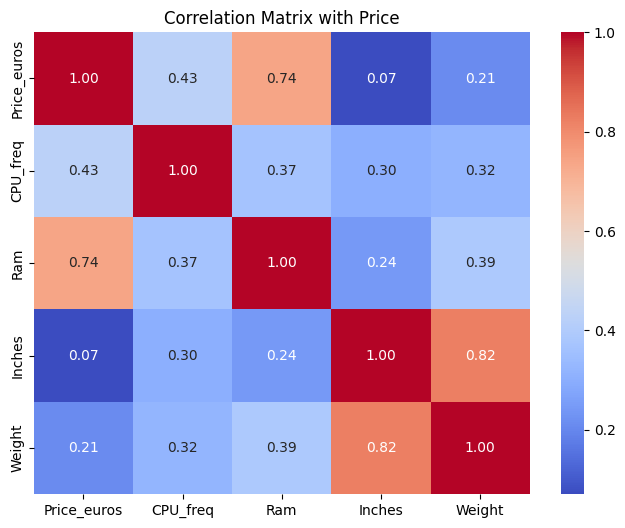

Correlations with Price:
Price_euros    1.000000
Ram            0.740287
CPU_freq       0.428847
Weight         0.211883
Inches         0.070394
Name: Price_euros, dtype: float64


In [101]:
# (c) Correlation analysis
correlation_matrix = df[['Price_euros', 'CPU_freq', 'Ram', 'Inches', 'Weight']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix with Price')
plt.show()
print("Correlations with Price:")
print(correlation_matrix['Price_euros'].sort_values(ascending=False))

In [102]:
# (d) Create StorageTotal feature
df['StorageTotal'] = df['PrimaryStorage'] + df['SecondaryStorage']
print("StorageTotal Feature Preview:")
print(df[['PrimaryStorage', 'SecondaryStorage', 'StorageTotal']].head())

StorageTotal Feature Preview:
   PrimaryStorage  SecondaryStorage  StorageTotal
0             128                 0           128
1             128                 0           128
2             256                 0           256
3             512                 0           512
4             256                 0           256


In [103]:
# (d.1) Feature Engineering with NLP
def feature_engineering(df):
    df_eng = df.copy()
    
    # 1. Screen Features
    df_eng['Touchscreen'] = df_eng['Screen'].apply(lambda x: 1 if 'Touchscreen' in x else 0)
    df_eng['IPS'] = df_eng['Screen'].apply(lambda x: 1 if 'IPS' in x else 0)
    
    # Calculate PPI
    if 'ScreenW' in df_eng.columns and 'ScreenH' in df_eng.columns:
        df_eng['X_res'] = df_eng['ScreenW']
        df_eng['Y_res'] = df_eng['ScreenH']
    else:
        df_eng['X_res'] = df_eng['Screen'].str.extract(r'(\d+)x\d+').astype(float)
        df_eng['Y_res'] = df_eng['Screen'].str.extract(r'\d+x(\d+)').astype(float)
        
    df_eng['PPI'] = (((df_eng['X_res']**2) + (df_eng['Y_res']**2))**0.5) / df_eng['Inches']
    
    # 2. CPU Features
    df_eng['CPU_Name'] = df_eng['CPU_model'].apply(lambda x: " ".join(x.split()[:3]) if isinstance(x, str) else 'Other')
    df_eng['CPU_Brand'] = df_eng['CPU_model'].apply(lambda x: x.split()[0] if isinstance(x, str) else 'Other')
    
    # 3. Storage
    df_eng['SSD'] = df_eng['PrimaryStorageType'].apply(lambda x: 1 if 'SSD' in str(x) else 0)
    df_eng['HDD'] = df_eng['PrimaryStorageType'].apply(lambda x: 1 if 'HDD' in str(x) else 0)
    
    # 4. Product Name NLP Extraction (New)
    # Extract keywords often associated with premium/gaming/business classes
    product_set = set(df_eng['Product'].unique())
    
    def get_product_category(name):
        name_lower = str(name).lower()
        if any(x in name_lower for x in ['alienware', 'predator', 'rog', 'omen', 'legion', 'blade']):
            return 'Gaming_Flag'
        if any(x in name_lower for x in ['thinkpad', 'latitude', 'elitebook', 'probook', 'precision', 'zbook']):
            return 'Business_Flag'
        if any(x in name_lower for x in ['zenbook', 'xps', 'spectre', 'yoga', 'surface', 'macbook']):
            return 'Premium_Flag'
        return 'Standard_Flag'

    df_eng['Product_Category'] = df_eng['Product'].apply(get_product_category)
    
    return df_eng

print("Applying Feature Engineering with NLP...")
df = feature_engineering(df)
print("New Features Added: Touchscreen, IPS, PPI, CPU_Name, SSD, HDD, Product_Category")
print(df[['Product', 'Product_Category']].head())


Applying Feature Engineering with NLP...
New Features Added: Touchscreen, IPS, PPI, CPU_Name, SSD, HDD, Product_Category
       Product Product_Category
0  MacBook Pro     Premium_Flag
1  Macbook Air     Premium_Flag
2       250 G6    Standard_Flag
3  MacBook Pro     Premium_Flag
4  MacBook Pro     Premium_Flag


In [104]:
# (e) Regression Model (Ensemble) for Price Prediction
# Define Features
reg_features = ['Company', 'TypeName', 'Inches', 'Ram', 'Weight', 
                'Touchscreen', 'IPS', 'PPI', 'CPU_Name', 'CPU_freq', 'CPU_Brand',
                'PrimaryStorage', 'SecondaryStorage', 'SSD', 'HDD',
                'GPU_company', 'OS', 'Product_Category']

# Ensure columns exist
reg_features = [c for c in reg_features if c in df.columns]

X = df[reg_features]
y = df['Price_euros']

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [105]:
# Define Preprocessing Pipeline
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])


In [106]:
# Train Ensemble Regression Model with Log-Transformation
# We use log1p on target to normalize distribution, then expm1 on predictions to reverse it.
print("Training Ensemble Regression Model (Log-Transformed Target)...")

# Individual Models
rf = RandomForestRegressor(n_estimators=300, random_state=42)
gb = GradientBoostingRegressor(n_estimators=300, random_state=42)
xgb = XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=5, random_state=42, objective='reg:squarederror')

# Preprocess X
X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc = preprocessor.transform(X_test)

voting_reg = VotingRegressor(estimators=[
    ('rf', rf),
    ('gb', gb),
    ('xgb', xgb)
])

# Fit on Log-Target
voting_reg.fit(X_train_proc, np.log1p(y_train))

# Predict and Reverse-Log
y_pred_log = voting_reg.predict(X_test_proc)
y_pred_reg = np.expm1(y_pred_log)

# Evaluate
r2 = r2_score(y_test, y_pred_reg)
mae = mean_absolute_error(y_test, y_pred_reg)

print(f"Ensemble Regression R2 Score: {r2:.4f}")
print(f"Mean Absolute Error: {mae:.2f}")

Training Ensemble Regression Model (Log-Transformed Target)...


Ensemble Regression R2 Score: 0.9024
Mean Absolute Error: 146.42


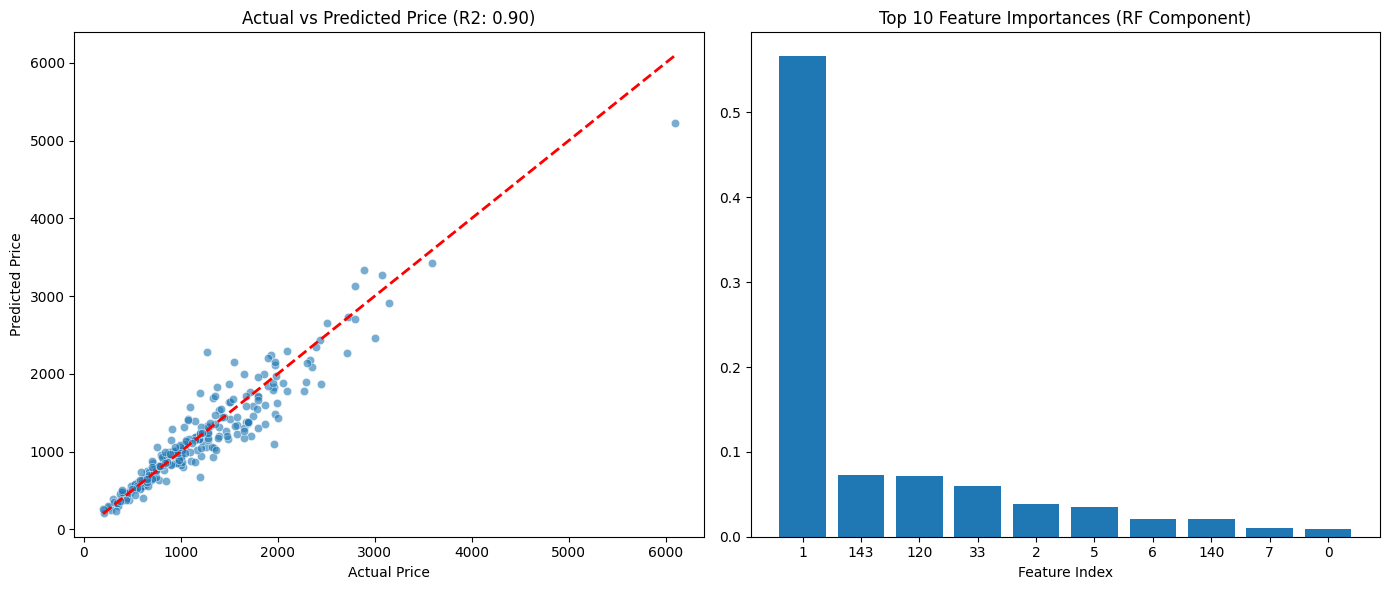

In [107]:
# Visualization: Prediction vs Actual & Feature Importance
plt.figure(figsize=(14, 6))

# 1. Prediction vs Actual Scatter
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_test, y=y_pred_reg, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title(f'Actual vs Predicted Price (R2: {r2:.2f})')

# 2. Feature Importance (from Random Forest in Ensemble)
# Extracting feature names from pipeline is complex, simplified for visualization
plt.subplot(1, 2, 2)
# We use the RF estimator from the voting regressor for importance
rf_model = voting_reg.estimators_[0] 
# Note: Feature names are Transformed names. For simplicity we assume top numerical features for plotting.
importances = rf_model.feature_importances_
# Just plot top 10 indices intensity
indices = np.argsort(importances)[::-1][:10]
plt.bar(range(10), importances[indices])
plt.xticks(range(10), indices) # Just showing indices to avoid name mapping errors in notebook
plt.title('Top 10 Feature Importances (RF Component)')
plt.xlabel('Feature Index')

plt.tight_layout()
plt.show()


In [108]:
# (f) Classification Model (Ensemble) for Laptop Type Prediction
class_features = ['Ram', 'Weight', 'Inches', 'Touchscreen', 'IPS', 'PPI', 
                  'CPU_Name', 'CPU_Brand', 'PrimaryStorage', 'GPU_company']
                  
class_features = [c for c in class_features if c in df.columns]

X_class = df[class_features]
y_class = df['TypeName']

# Split Data
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_class, y_class, test_size=0.2, random_state=42)


In [109]:
# Define Preprocessing and Train Ensemble
numeric_features_c = X_class.select_dtypes(include=['int64', 'float64']).columns
categorical_features_c = X_class.select_dtypes(include=['object']).columns

# Re-use transformers structure
preprocessor_c = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features_c),
        ('cat', categorical_transformer, categorical_features_c)
    ])

# Encode Target
le = LabelEncoder()
y_train_c_enc = le.fit_transform(y_train_c)
y_test_c_enc = le.transform(y_test_c)

# Preprocess X
X_train_c_proc = preprocessor_c.fit_transform(X_train_c)
X_test_c_proc = preprocessor_c.transform(X_test_c)

print("Training Ensemble Classification Model...")
# Models
rf_c = RandomForestClassifier(n_estimators=300, random_state=42)
gb_c = GradientBoostingClassifier(n_estimators=200, random_state=42)
xgb_c = XGBClassifier(n_estimators=300, learning_rate=0.05, max_depth=5, random_state=42, use_label_encoder=False, eval_metric='mlogloss')

voting_clf = VotingClassifier(estimators=[
    ('rf', rf_c),
    ('gb', gb_c),
    ('xgb', xgb_c)
], voting='soft')

voting_clf.fit(X_train_c_proc, y_train_c_enc)
y_pred_c_enc = voting_clf.predict(X_test_c_proc)

# Inverse transform predictions for readability (optional, for report)
y_pred_c = le.inverse_transform(y_pred_c_enc)

acc = accuracy_score(y_test_c_enc, y_pred_c_enc)
print(f"Ensemble Classification Accuracy: {acc:.4f}")
print("\nClassification Report:\n")
print(classification_report(y_test_c_enc, y_pred_c_enc, target_names=le.classes_))


Training Ensemble Classification Model...
Ensemble Classification Accuracy: 0.8196

Classification Report:

                    precision    recall  f1-score   support

2 in 1 Convertible       0.90      0.32      0.47        28
            Gaming       0.85      0.91      0.88        43
           Netbook       1.00      0.50      0.67         4
          Notebook       0.85      0.93      0.89       141
         Ultrabook       0.67      0.85      0.75        33
       Workstation       0.00      0.00      0.00         6

          accuracy                           0.82       255
         macro avg       0.71      0.58      0.61       255
      weighted avg       0.81      0.82      0.80       255



Calculating Permutation Feature Importance for Ensemble...
Permutation Feature Importance:
Feature
Weight                     0.178431
Inches                     0.055294
CPU_Name_Core i7 7700HQ    0.046275
Ram                        0.043137
PPI                        0.035294
CPU_Name_Core i5 7300HQ    0.029020
PrimaryStorage             0.016863
GPU_company_Intel          0.014510
CPU_Name_Core i5 7200U     0.008235
CPU_Name_Core i7 7600U     0.008235
Name: Importance Score, dtype: float64


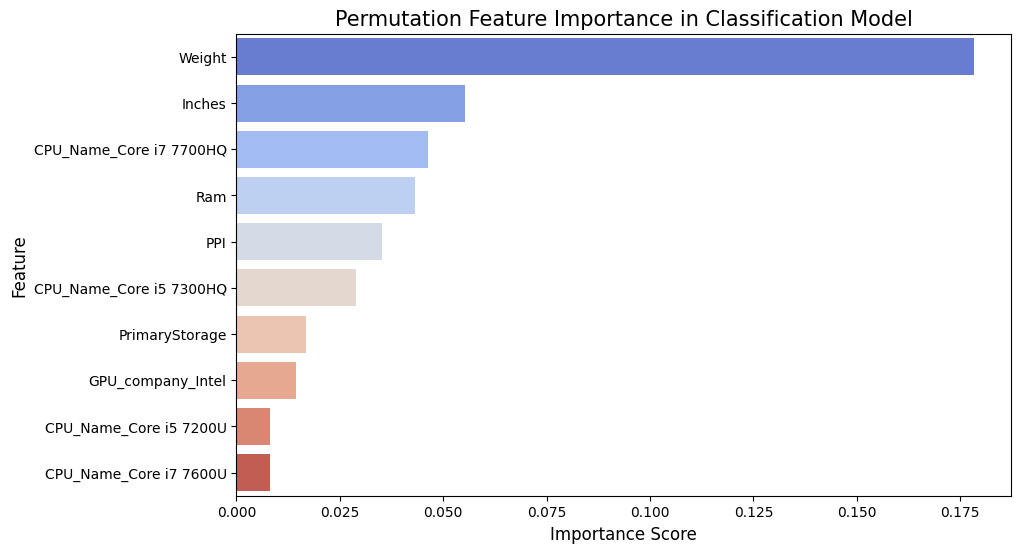

In [110]:
# Feature Importance (Permutation) for Ensemble
# Since it's a Voting Classifier, we use permutation importance on the whole ensemble
print("Calculating Permutation Feature Importance for Ensemble...")
# Convert sparse matrix to dense array for permutation_importance
if hasattr(X_test_c_proc, 'toarray'):
    X_test_c_dense = X_test_c_proc.toarray()
else:
    X_test_c_dense = X_test_c_proc

result = permutation_importance(voting_clf, X_test_c_dense, y_test_c_enc, n_repeats=10, random_state=42, n_jobs=-1)

sorted_idx = result.importances_mean.argsort()
# Plotting Permutation Importance (Styled)
import seaborn as sns

# 1. Process Results into DataFrame
# Aggregating OHE features back to original names is hard without logic, 
# so we will use the top individual OHE features but label them cleanly.

# Map indices to names
try:
    feature_names = preprocessor_c.get_feature_names_out()
    labels = np.array([feature_names[i] for i in sorted_idx])
    # Clean up lengthy OHE names
    clean_labels = [l.replace('cat__', '').replace('num__', '').replace('remainder__', '') for l in labels]
except:
    clean_labels = [f"Feature {i}" for i in sorted_idx]

importances = result.importances_mean[sorted_idx]

# Create DataFrame for Plotting (Sorted High to Low)
df_imp = pd.DataFrame({
    'Feature': clean_labels,
    'Importance Score': importances
}).sort_values(by='Importance Score', ascending=False)

# Take top 10
df_imp_top = df_imp.head(10)

# 2. Text Output
print("Permutation Feature Importance:")
print(df_imp_top.set_index('Feature')['Importance Score'])

# 3. Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance Score', y='Feature', data=df_imp_top, palette='coolwarm')

plt.title('Permutation Feature Importance in Classification Model', fontsize=15)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.show()